In [2]:
import uproot as ur
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
from tqdm import tqdm

In [25]:
plt.rcParams.update({
    "font.size": 14,             # Default font size for all text
    "axes.labelsize": 16,        # X and Y labels
    "axes.titlesize": 18,        # Title
    "xtick.labelsize": 12,       # X tick labels
    "ytick.labelsize": 12,       # Y tick labels
    "legend.fontsize": 14,       # Legend text
    "figure.titlesize": 20       # Figure-wide title
})

In [26]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
OUTPUT_DIR = os.path.join(PROJECT_ROOT, "output", "DEBUG_RUN", "converted")

paths = {
    "optimized": os.path.join(OUTPUT_DIR, "optimized_converted_run1.root"),
    "opt_ind": os.path.join(OUTPUT_DIR, "opt_ind_converted_run1.root"),
    "legacy": os.path.join(OUTPUT_DIR, "legacy_converted_run1.root"),
}

data_all = {}
for key, path in paths.items():
    with ur.open(path) as f:
        tree = f["pulse"]
        data_all[key] = {
            "channel": tree["channel"].array(library="np"),
            "time": tree["time"].array(library="np")
        }


In [27]:
for name in data_all:
    print(f"{name:10s} shape = {data_all[name]['channel'].shape}")

optimized  shape = (1000, 7, 5002)
opt_ind    shape = (1000, 7, 5002)
legacy     shape = (1000, 7, 5002)


In [28]:
def compare_pair(name1, name2, threshold=1e-3):
    ch1 = data_all[name1]["channel"]
    ch2 = data_all[name2]["channel"]
    t1 = data_all[name1]["time"]
    t2 = data_all[name2]["time"]

    assert ch1.shape == ch2.shape, "Shape mismatch"
    print(f"\n🔍 Comparing: {name1} vs {name2}")

    diff = ch1 - ch2
    tdiff = t1 - t2

    print(f"  Mean(abs diff):    {np.mean(np.abs(diff)):.4e}")
    print(f"  Max(abs diff):     {np.max(np.abs(diff)):.4e}")
    print(f"  Std(abs diff):     {np.std(diff):.4e}")

    print(f"  Time axis max diff: {np.max(np.abs(tdiff)):.4e}")

    # Report any large mismatch
    count = 0
    for evt in range(min(10, ch1.shape[0])):
        for ch in range(ch1.shape[1]):
            d = ch1[evt, ch, :] - ch2[evt, ch, :]
            if np.max(np.abs(d)) > threshold:
                print(f"  ⚠️  Mismatch in evt={evt}, ch={ch}, max diff={np.max(np.abs(d)):.4e}")
                count += 1
    if count == 0:
        print("  ✅ No significant mismatches found.")

In [29]:
# Do all pairwise comparisons
compare_pair("optimized", "opt_ind")    # Should be 100% match
compare_pair("optimized", "legacy")     # Expect small diffs
compare_pair("opt_ind", "legacy")       # Expect small diffs


🔍 Comparing: optimized vs opt_ind
  Mean(abs diff):    0.0000e+00
  Max(abs diff):     0.0000e+00
  Std(abs diff):     0.0000e+00
  Time axis max diff: 0.0000e+00
  ✅ No significant mismatches found.

🔍 Comparing: optimized vs legacy
  Mean(abs diff):    0.0000e+00
  Max(abs diff):     0.0000e+00
  Std(abs diff):     0.0000e+00
  Time axis max diff: 2.8422e-14
  ✅ No significant mismatches found.

🔍 Comparing: opt_ind vs legacy
  Mean(abs diff):    0.0000e+00
  Max(abs diff):     0.0000e+00
  Std(abs diff):     0.0000e+00
  Time axis max diff: 2.8422e-14
  ✅ No significant mismatches found.


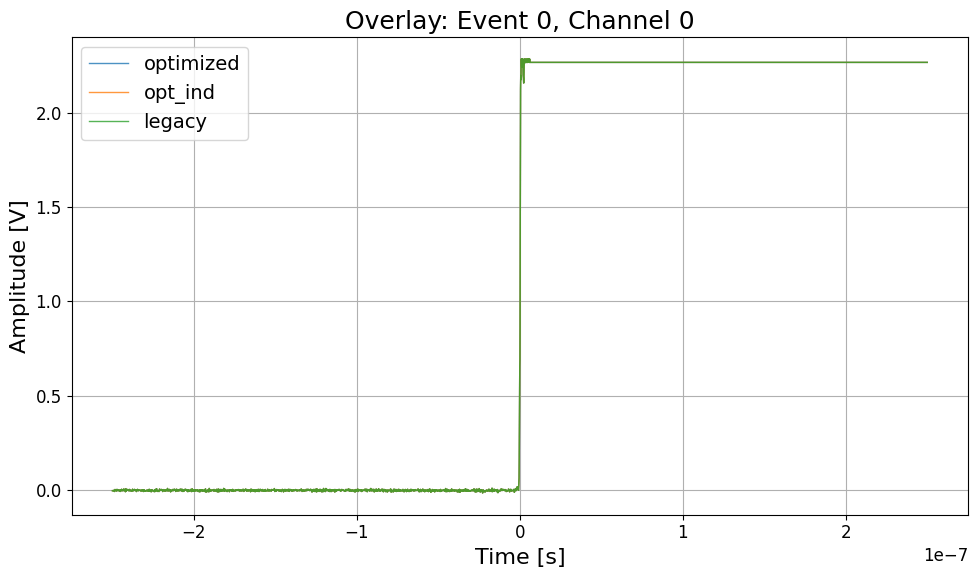

In [35]:
# Visualization: One example
def plot_overlay(event_idx=0, channel_idx=0):
    plt.figure(figsize=(10, 6))
    for name, color in zip(["optimized", "opt_ind", "legacy"], ["black", "blue", "red"]):
        t = data_all[name]["time"][event_idx, channel_idx, :]
        y = data_all[name]["channel"][event_idx, channel_idx, :]
        plt.plot(t, y, label=name, alpha=0.8, lw=1)

    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude [V]")
    plt.title(f"Overlay: Event {event_idx}, Channel {channel_idx}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_overlay(event_idx=0, channel_idx=0)

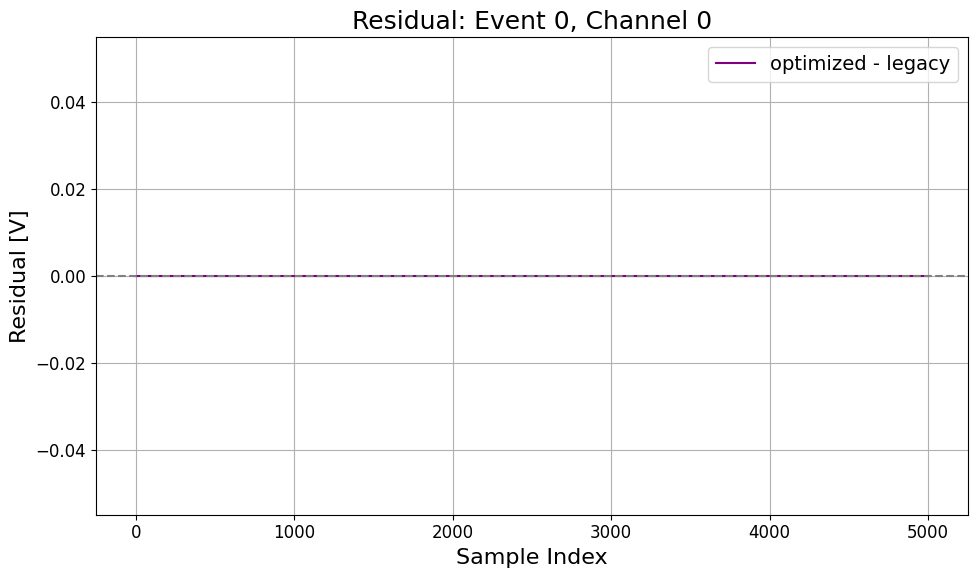

In [36]:
# Residual plot
def plot_residual(event_idx=0, channel_idx=0):
    plt.figure(figsize=(10, 6))
    d_ol = data_all["optimized"]["channel"][event_idx, channel_idx, :] - data_all["legacy"]["channel"][event_idx, channel_idx, :]
    plt.plot(d_ol, label="optimized - legacy", color="purple")
    plt.axhline(0, color="gray", linestyle="--")
    plt.xlabel("Sample Index")
    plt.ylabel("Residual [V]")
    plt.title(f"Residual: Event {event_idx}, Channel {channel_idx}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_residual(event_idx=0, channel_idx=0)

In [37]:
def check_time_axis(event_idx=0, n_samples=500):
    plt.figure(figsize=(10, 6))
    for name, color in zip(["optimized", "opt_ind", "legacy"], ["black", "blue", "red"]):
        t = data_all[name]["time"][event_idx, 0, :n_samples]
        plt.plot(t, label=f"{name}", alpha=0.8)
    plt.xlabel("Sample Index")
    plt.ylabel("Time [s]")
    plt.title(f"Time axis comparison for Event {event_idx}, Channel 0")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_time_deltas(event_idx=0, channel_idx=0):
    plt.figure(figsize=(10, 6))
    for name, color in zip(["optimized", "opt_ind", "legacy"], ["black", "blue", "red"]):
        t = data_all[name]["time"][event_idx, channel_idx, :]
        dt = np.diff(t)
        plt.hist(dt, label=name, alpha=0.8)
    plt.xlabel("Sample Index")
    plt.ylabel("Δt [s]")
    plt.title(f"Time delta (Δt) for Event {event_idx}, Channel {channel_idx}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_all_channels_time(event_idx=0, name="legacy"):
    plt.figure(figsize=(10, 6))
    for ch in range(data_all[name]["time"].shape[1]):
        t = data_all[name]["time"][event_idx, ch, :]
        plt.plot(t, label=f"Ch{ch+1}")
    plt.xlabel("Sample Index")
    plt.ylabel("Time [s]")
    plt.title(f"Time axis across channels: {name} | Event {event_idx}")
    plt.legend(ncol=4)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_time_error_to_linear(event_idx=0, channel_idx=0, name="legacy"):
    t = data_all[name]["time"][event_idx, channel_idx, :]
    linear_ref = np.linspace(t[0], t[0] + len(t) * np.mean(np.diff(t)), len(t))
    err = t - linear_ref
    plt.figure(figsize=(10, 4))
    plt.plot(err)
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(f"Deviation from Linear Time: {name}, Event {event_idx}, Channel {channel_idx}")
    plt.xlabel("Sample Index")
    plt.ylabel("Error [s]")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


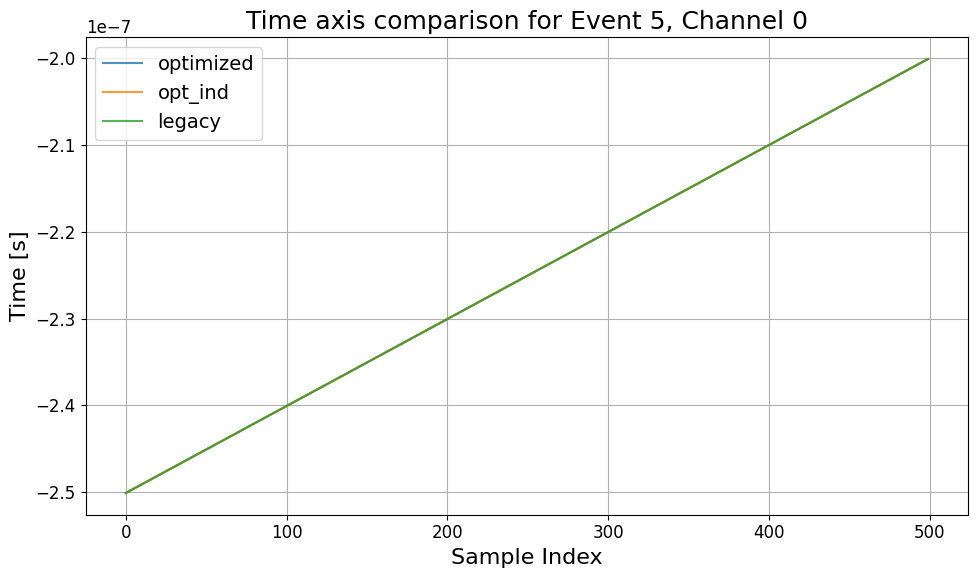

In [44]:
check_time_axis(event_idx=5)

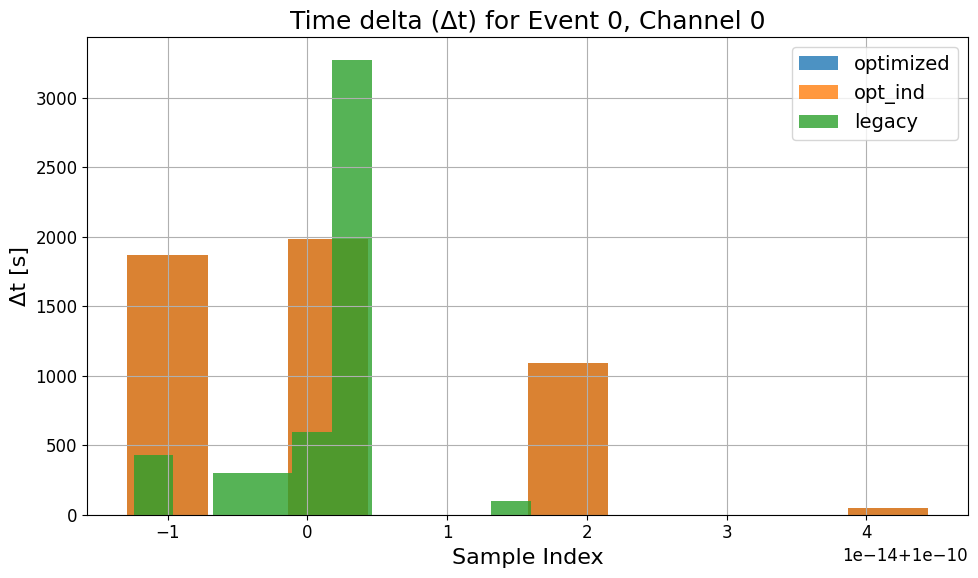

In [40]:
plot_time_deltas(event_idx=0, channel_idx=0)

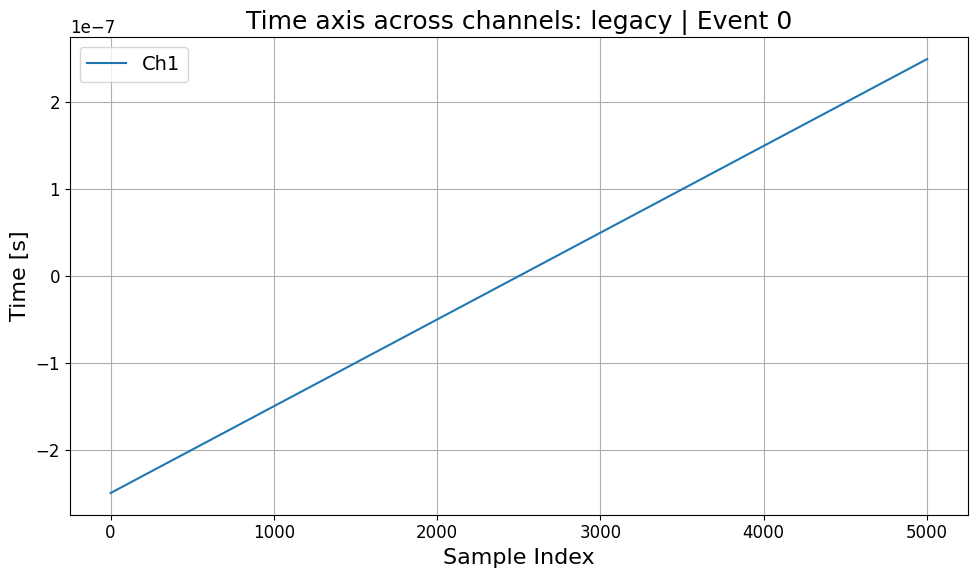

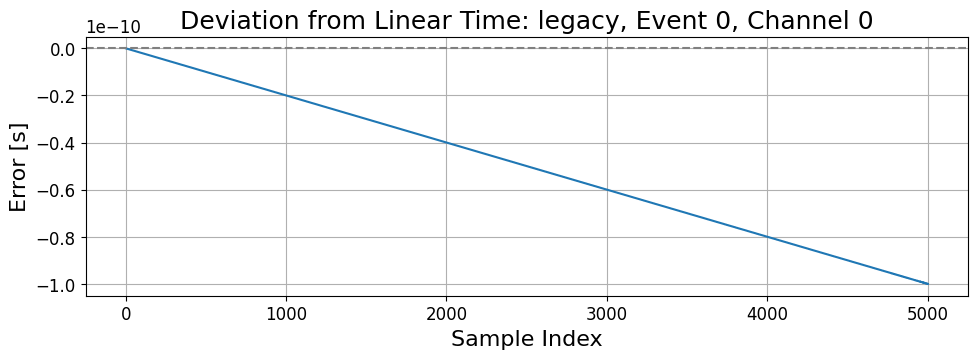

In [41]:
plot_all_channels_time(event_idx=0, name="legacy")
plot_time_error_to_linear(event_idx=0, channel_idx=0, name="legacy")